In [2]:
!pip install tensorflow pandas scikit-learn

In [3]:
!mkdir input
!cd input && wget https://github.com/sourcepirate/sg5238-iot-pretrained/raw/master/Dataset/sign-language-mnist.zip
!cd input && unzip sign-language-mnist.zip

--2019-05-05 03:41:04--  https://github.com/sourcepirate/sg5238-iot-pretrained/raw/master/Dataset/sign-language-mnist.zip
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sourcepirate/sg5238-iot-pretrained/master/Dataset/sign-language-mnist.zip [following]
--2019-05-05 03:41:04--  https://raw.githubusercontent.com/sourcepirate/sg5238-iot-pretrained/master/Dataset/sign-language-mnist.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32286533 (31M) [application/zip]
Saving to: ‘sign-language-mnist.zip’

sign-language-mnist 100%[===================>]  30.79M   165MB/s    in 0.2s    

2019-05-05 03:

In [4]:
!ls input/

american_sign_language.PNG  amer_sign3.png	     sign_mnist_test.csv
amer_sign2.png		    sign-language-mnist.zip  sign_mnist_train.csv


In [5]:
## Since all the dataset has been configured let proceed examining 
## the model.

import warnings
import os

warnings.filterwarnings('ignore')
print(os.listdir("input/"))


['amer_sign3.png', 'sign_mnist_test.csv', 'amer_sign2.png', 'sign-language-mnist.zip', 'sign_mnist_train.csv', 'american_sign_language.PNG']


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

**Strip the data frames **

In [0]:
data = pd.read_csv('./input/sign_mnist_train.csv')

In [8]:
print(data.shape)

(27455, 785)


In [9]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [10]:
## data description

print(f"Number of images: {len(data.iloc[:, :1].values)}")
print(f"Pixel square of : {data.shape[1]}")

Number of images: 27455
Pixel square of : 785


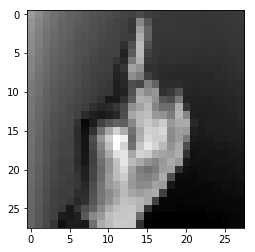

In [11]:
x = data.iloc[:, 1:].values
y = data.iloc[:, :1].values.flatten()
img_arr = np.asarray(x[0].reshape(28, 28))
plt.imshow(img_arr, cmap="binary")

In [0]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [0]:
def display_images(data):
    x, y = data
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(chr(y[i] + 65))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

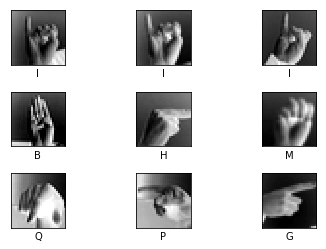

In [14]:
display_images(next_batch(9, x, y))

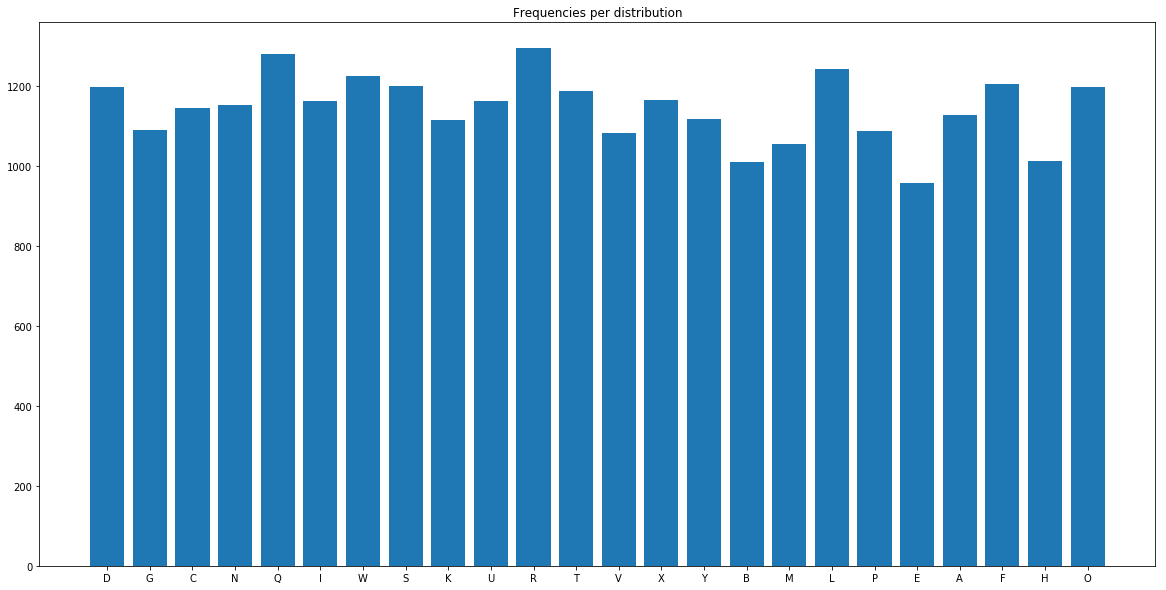

In [15]:
z = Counter(list(y))
labels = []
frequencies = []
for l, f in z.items():
  labels.append(chr(l + 65))
  frequencies.append(f)

plt.figure(figsize=(20, 10))
plt.bar(labels, frequencies)
plt.title('Frequencies per distribution')
plt.show()

In [16]:
print(f"No of unique labels {len(labels)}")

No of unique labels 24


**Start training CNN & RNN**

In [17]:
def one_hot_encode(y):
    return np.eye(25)[y]
output_array = one_hot_encode(y)
print(f"Encoding shape {output_array.shape}")

Encoding shape (27455, 25)


In [0]:
learning_rate = 0.001
epochs = 2000
batch_size = 128
display_step = 100

In [0]:
# Hyper params
n_input = 784
n_classes = 25
dropout = 0.75

In [0]:
X = tf.placeholder(tf.float32, shape=[None, n_input])
Y = tf.placeholder(tf.float32, shape=[None, n_classes])
keep_prob = tf.placeholder(tf.float32)

In [21]:
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 25(number of classes) output channels
    'w4' : tf.Variable(tf.random_normal([1024, n_classes]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random_normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random_normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random_normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random_normal([n_classes]))
}

In [0]:
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [0]:
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [0]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out

In [26]:
logits = neural_network(X, weights, biases, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

In [0]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
init = tf.global_variables_initializer()


In [30]:
# Splitting the dataset into Training and Holdout(Test set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, output_array, test_size = 0.33, random_state = 42)
print('X train shape', X_train.shape)
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)
print('y test shape', y_test.shape)

X train shape (18394, 784)
y train shape (18394, 25)
X test shape (9061, 784)
y test shape (9061, 25)


In [31]:
with tf.Session() as sess:
    # Running Initializer
    sess.run(init)
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, X_train, y_train)
        # Running Optimizer
        sess.run(train_op, feed_dict = { X : _x, Y : _y, keep_prob : dropout })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y, keep_prob : 1.0 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy on Training Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : X_train,
                                                           Y : y_train,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    print('Accuracy on Test Data: ' + str(sess.run(accuracy,
                                                   feed_dict = {
                                                       X : X_test,
                                                       Y : y_test,
                                                       keep_prob : 1.0
                                                   }) * 100) + ' %')

Epoch 100, Cost: 111936396.625, Accuracy: 32.8125 %
Epoch 200, Cost: 30620784.4375, Accuracy: 67.1875 %
Epoch 300, Cost: 13663317.875, Accuracy: 83.59375 %
Epoch 400, Cost: 6255281.9375, Accuracy: 87.5 %
Epoch 500, Cost: 3899845.6875, Accuracy: 92.96875 %
Epoch 600, Cost: 498647.875, Accuracy: 96.09375 %
Epoch 700, Cost: 471222.4375, Accuracy: 99.21875 %
Epoch 800, Cost: 622478.1875, Accuracy: 98.4375 %
Epoch 900, Cost: 98949.625, Accuracy: 99.21875 %
Epoch 1000, Cost: 260126.375, Accuracy: 98.4375 %
Epoch 1100, Cost: 0.0, Accuracy: 100.0 %
Epoch 1200, Cost: 0.0, Accuracy: 100.0 %
Epoch 1300, Cost: 0.0, Accuracy: 100.0 %
Epoch 1400, Cost: 0.0, Accuracy: 100.0 %
Epoch 1500, Cost: 0.0, Accuracy: 100.0 %
Epoch 1600, Cost: 0.0, Accuracy: 100.0 %
Epoch 1700, Cost: 0.0, Accuracy: 100.0 %
Epoch 1800, Cost: 0.0, Accuracy: 100.0 %
Epoch 1900, Cost: 0.0, Accuracy: 100.0 %
Epoch 2000, Cost: 0.0, Accuracy: 100.0 %
--------------------------------------------------

Optimization Finished

Accuracy 

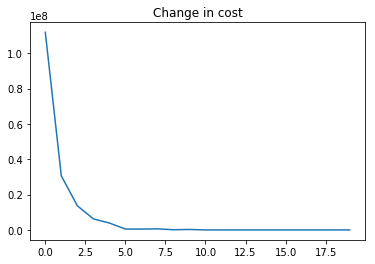

In [32]:
plt.plot(list(range(len(cost_hist))), cost_hist)
plt.title("Change in cost")
plt.show()

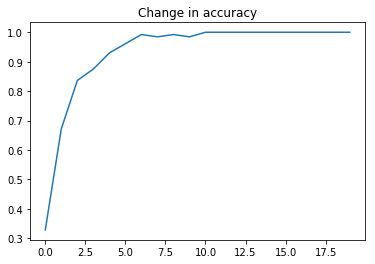

In [33]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.show()

In [36]:
print('Training on the whole dataset....\n')
with tf.Session() as sess:
    sess.run(init) # Running Initializer
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, x, output_array)
        # Running Optimizer
        sess.run(train_op,
                 feed_dict = {
                     X : _x,
                     Y : _y,
                     keep_prob : dropout
                 })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy],
                                 feed_dict = {
                                     X : _x,
                                     Y : _y,
                                     keep_prob : 1.0
                                 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy after training on whole dataset Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : x,
                                                           Y : output_array,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    W = sess.run(weights)
    B = sess.run(biases)

Training on the whole dataset....

Epoch 100, Cost: 136104993.625, Accuracy: 34.375 %
Epoch 200, Cost: 51330484.125, Accuracy: 55.46875 %
Epoch 300, Cost: 11648685.1875, Accuracy: 76.5625 %
Epoch 400, Cost: 9745254.96875, Accuracy: 74.21875 %
Epoch 500, Cost: 4267613.78125, Accuracy: 89.0625 %
Epoch 600, Cost: 2216161.40625, Accuracy: 88.28125 %
Epoch 700, Cost: 3068464.1875, Accuracy: 89.0625 %
Epoch 800, Cost: 1365135.875, Accuracy: 92.1875 %
Epoch 900, Cost: 573222.53125, Accuracy: 94.53125 %
Epoch 1000, Cost: 203126.6875, Accuracy: 97.65625 %
Epoch 1100, Cost: 579212.96875, Accuracy: 96.875 %
Epoch 1200, Cost: 0.0, Accuracy: 100.0 %
Epoch 1300, Cost: 206952.859375, Accuracy: 96.875 %
Epoch 1400, Cost: 159431.0625, Accuracy: 99.21875 %
Epoch 1500, Cost: 76619.75, Accuracy: 99.21875 %
Epoch 1600, Cost: 4024.40625, Accuracy: 99.21875 %
Epoch 1700, Cost: 0.0, Accuracy: 100.0 %
Epoch 1800, Cost: 0.0, Accuracy: 100.0 %
Epoch 1900, Cost: 0.0, Accuracy: 100.0 %
Epoch 2000, Cost: 0.0, Accur

In [38]:
data_test = pd.read_csv('input/sign_mnist_test.csv')
print('Dataframe Shape:', data_test.shape)

Dataframe Shape: (7172, 785)


In [39]:
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [40]:
x_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, :1].values.flatten()
y_test = one_hot_encode(y_test)
x_test.shape, y_test.shape

((7172, 784), (7172, 25))

In [0]:
X = tf.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32)

In [0]:
y_pred = neural_network(X, W, B, 1.0)


In [0]:
def get_prediction(img):
    with tf.Session() as sess:
        pred = sess.run(y_pred, feed_dict = { X : img, keep_prob : 1.0 })
    img = img.reshape(28, 28)
    pred = list(pred.flatten())
    pred = chr(pred.index(max(pred)) + 65)
    return (img, pred)

In [0]:
saver = tf.train.Saver()
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(init_op)
  tf.train.write_graph(sess.graph_def, '.', 'output/sign.pbtxt')  
  saver.save(sess, 'output/sign.ckpt')

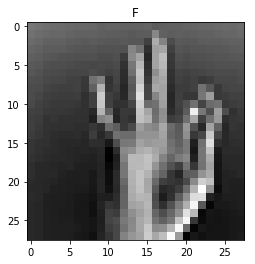

In [44]:
image, pred = get_prediction(x_test[1].reshape(1, 784))
plt.imshow(image, cmap = 'binary')
plt.title(pred)
plt.show()

In [47]:
!ls

checkpoint  sample_data			   sign.ckpt.index  sign.pbtxt
input	    sign.ckpt.data-00000-of-00001  sign.ckpt.meta


In [51]:
!ls output

checkpoint		       sign.ckpt.index	sign.pbtxt
sign.ckpt.data-00000-of-00001  sign.ckpt.meta


In [57]:
!tar -cvzf model.tar.gz output/


output/
output/sign.ckpt.index
output/checkpoint
output/sign.ckpt.data-00000-of-00001
output/sign.pbtxt
output/sign.ckpt.meta


In [0]:
from google.colab import files
files.download('model.tar.gz')